# Librerias

In [121]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree

# Tratando datos
## El unico
Como esta dataset esta separado en varias carpeta lo que he decidido es por cada categoria crear un unico fichero donde se agrupe todo los datos de esta categoria

In [122]:
all_files_idle = glob.glob("data/idle/*.csv")
all_files_running = glob.glob("data/running/*.csv")
all_files_stairs = glob.glob("data/stairs/*.csv")
all_files_walking = glob.glob("data/walking/*.csv")

df_from_each_file_idle = (pd.read_csv(f) for f in all_files_idle)
df_from_each_file_running = (pd.read_csv(f) for f in all_files_running)
df_from_each_file_stairs = (pd.read_csv(f) for f in all_files_stairs)
df_from_each_file_walking = (pd.read_csv(f) for f in all_files_walking)

df_idle = pd.concat(df_from_each_file_idle, axis=0, ignore_index=True)
df_idle = df_idle.assign(action=0)

df_running = pd.concat(df_from_each_file_running, axis=0, ignore_index=True)
df_running = df_running.assign(action=1)

df_stairs = pd.concat(df_from_each_file_stairs, axis=0, ignore_index=True)
df_stairs = df_stairs.assign(action=2)

df_walking = pd.concat(df_from_each_file_walking, axis=0, ignore_index=True)
df_walking = df_walking.assign(action=3)

Generamos nuestro dataset (los 4 ficheros convertidos a 1) y printamos los 5 primeros elementos

In [123]:
df = pd.concat([df_idle, df_running, df_stairs, df_walking], axis=0, ignore_index=True)
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,action
0,1.000776,4.616021,8.576031,0
1,0.718261,4.209007,8.446744,0
2,-0.909797,-0.282516,9.203311,0
3,5.099650,0.148441,8.418014,0
4,1.762132,-0.162806,9.251195,0


## Entender los datos
Miramos que no tengamos nulos antes de todo

In [124]:
df.isnull().sum()

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
action             0
dtype: int64

<AxesSubplot:>

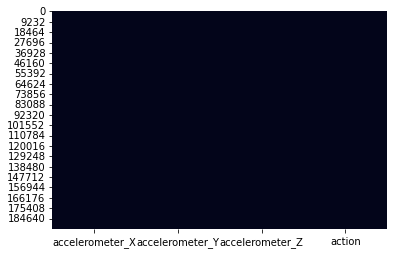

In [125]:
sns.heatmap(df.isnull(), cbar=False)

Mostramos descripcion de cada una para asi saber en que valores se encutran

In [126]:
print("IDLE", df_idle.describe(),"\n")
print("RUNNING",df_running.describe(),"\n")
print("STAIRS", df_stairs.describe(),"\n")
print("WALKING",df_walking.describe(),"\n")
print("DATASET", df.describe(),"\n")

IDLE        accelerometer_X  accelerometer_Y  accelerometer_Z   action
count     31170.000000     31170.000000     31170.000000  31170.0
mean          0.096767         2.225971         8.973247      0.0
std           0.691892         2.821235         1.211058      0.0
min         -10.448297        -2.595315        -0.296881      0.0
25%          -0.110133        -0.028730         8.116344      0.0
50%           0.234632         0.028730         9.749189      0.0
75%           0.277727         5.310340         9.773131      0.0
max           8.135497         9.916783        21.988348      0.0 

RUNNING        accelerometer_X  accelerometer_Y  accelerometer_Z    action
count    102240.000000    102240.000000    102240.000000  102240.0
mean          5.045705         8.083135         1.387356       1.0
std           9.952696        12.441402         7.004236       0.0
min         -39.188293       -39.188293       -39.188293       1.0
25%          -1.532289        -0.742202        -2.873042

Informacion de los datos

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   action           193860 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 5.9 MB


Podemos observar que en nuestro dataset no tenemos las misma cantidas de muestras para cada categoria, esto podria ser un problema para el entrenamiento de nuestro modelo. 

In [128]:
activity_labels = ['idle', 'running', 'stairs', 'walking']
for activity in activity_labels:
    file_names_list = os.listdir(os.path.join('data', activity))
    print(activity, ': ', len(file_names_list))

idle :  1039
running :  3408
stairs :  165
walking :  1850


Creamos las funciones necesarias para poder mostrar una grafica de nuestros datos

In [129]:
def plot_3d_trajectory(x, y, z, title):
    x = cumtrapz(x)
    y = cumtrapz(y)
    z = cumtrapz(z)
    
    fig3,ax = plt.subplots()
    fig3.suptitle(title,fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(x,y,z,c='red',lw=1,label='phone trajectory')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.show()

def select_actributs(avtivity):
    x = avtivity.accelerometer_X.values
    y = avtivity.accelerometer_Y.values
    z = avtivity.accelerometer_Z.values
    return x, y, z
    
def select_random_df(folder_name):
    custom_path = os.path.join('data/', folder_name)
    data = pd.read_csv(os.path.join(custom_path, os.listdir(custom_path)[0]))
    x = data.accelerometer_X.values
    y = data.accelerometer_Y.values
    z = data.accelerometer_Z.values
    return x, y, z

mostramos la distribucion de los datos

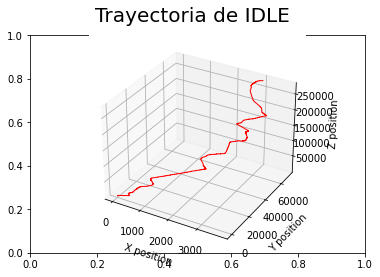

In [130]:
# Idle
x,y,z = select_actributs(df_idle)
plot_3d_trajectory(x, y, z, 'Trayectoria de IDLE')

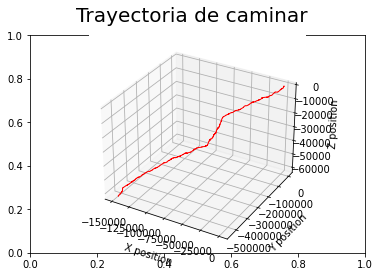

In [131]:
# Walking
x,y,z = select_actributs(df_walking)
plot_3d_trajectory(x, y, z, 'Trayectoria de caminar')

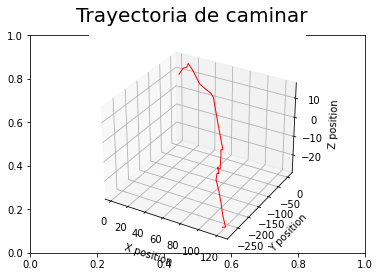

In [132]:
# Walking
x,y,z = select_random_df('walking')
plot_3d_trajectory(x, y, z, 'Trayectoria de caminar')

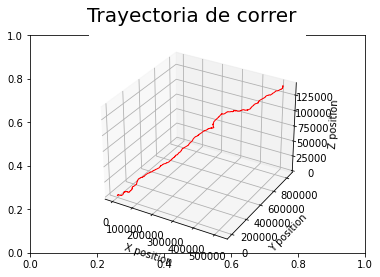

In [133]:
# running
x,y,z = select_actributs(df_running)
plot_3d_trajectory(x, y, z, 'Trayectoria de correr')

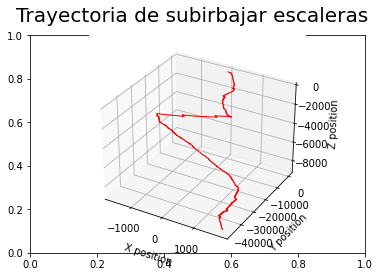

In [134]:
# stairs
x,y,z = select_actributs(df_stairs)
plot_3d_trajectory(x, y, z, 'Trayectoria de subirbajar escaleras')

Matriz de relacion entre las variables

<AxesSubplot:>

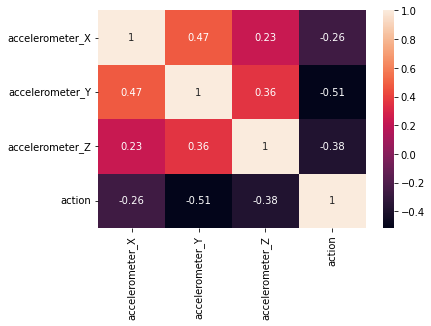

In [135]:
sns.heatmap(df.corr(), annot=True)

## Union de trayectorias

Como podemos observar, nuestro dataset esta compuesto por muchos ficheros de cada categoria, pero seria un error entrenar con este dataset ya que no estamos teniendo en cuenta las trayectorias, solo los puntos, para solucionar esto tranformaremos nuestro dataset en un dataset de medisa por cada fichero (trayectoria)

In [136]:
def mean_calculator(trayectoria):
    trayectoria_ejes = np.array(trayectoria)
    x = trayectoria_ejes[:, 0]
    y = trayectoria_ejes[:, 1]
    z = trayectoria_ejes[:, 2]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    z_mean = np.mean(x)
    return x_mean, y_mean, z_mean

In [137]:
def feature_engineer(action, target, df):
    x_mean, y_mean, z_mean = mean_calculator(action)
    dictionary = {
        'x_mean': x_mean,
        'y_mean': y_mean, 
        'z_mean': z_mean,
        'target': target
    }
    df = df.append(dictionary, ignore_index=True)
    return df

In [138]:
columns = ['x_mean', 'y_mean', 'z_mean', 'target']
dataframe = pd.DataFrame(columns=columns)

for activity in activity_labels:
    activity_files = os.listdir(os.path.join('data', activity))
    for file in activity_files:
        df = pd.read_csv(os.path.join('data', activity, file))
        array = df.to_numpy()
        dataframe = feature_engineer(array, activity, dataframe)

In [139]:
print(dataframe.shape)
dataframe.head()

(6462, 4)


,x_mean,y_mean,z_mean,target
0,0.178448,0.167435,0.178448,idle
1,-0.098641,-0.131202,-0.098641,idle
2,-0.099918,0.220905,-0.099918,idle
3,0.400949,-0.029528,0.400949,idle
4,0.400949,-0.027134,0.400949,idle


# Creacion del Modelo

## Antes de todo
Vamos a dividir nuestro dataset en entreno y test, personalmente me gusta la distribucion de 80% entreno y el 20% restante para el test

In [140]:
X = dataframe[['x_mean', 'y_mean', 'z_mean']]
Y = dataframe['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Clasificador

### SVM: rbf

Entrenamos nuestro modelo

In [141]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC()

Vamos ha ver que tal efectivo es

In [142]:
print("Efectividad del entreno:", svm_model.score(X_train, y_train))
print("Efectividad del test: ", svm_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model.predict(X_test), average='macro'))

Efectividad del entreno: 0.971174308376862
Efectividad del test:  0.97138437741686
F1-Sore:  0.7346459690053262


Vamos ha hecharle un vistazo a nuestra matriz de confusion, podemos observar que para las clases 0,1 y 3 tenemos muy buena clasificacion, pero sin embargo para la clase 2 ha fallado bastante, esto se debe a que nuestro datos estan desvalanzeados en el sentido que de la clase 2 (stairs) no tiene muchas muestras, por lo que no se puede clasificar con una buena precision.

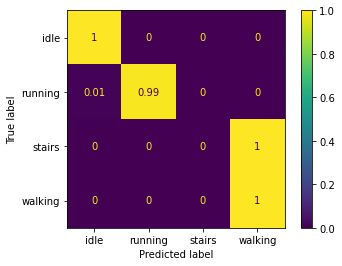

In [143]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, normalize='true')

### SVM: linear

In [144]:
svm_model_linear = svm.SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [145]:
print("Efectividad del entreno:", svm_model_linear.score(X_train, y_train))
print("Efectividad del test: ", svm_model_linear.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_linear.predict(X_test), average='macro'))

Efectividad del entreno: 0.943122460824144
Efectividad del test:  0.951276102088167
F1-Sore:  0.7150620915837145


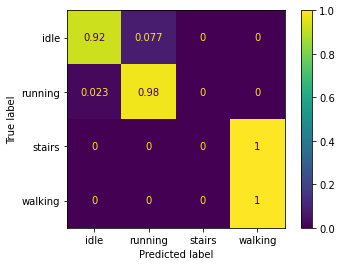

In [146]:
ConfusionMatrixDisplay.from_estimator(svm_model_linear, X_test, y_test, normalize='true')

### SVM: poly


In [147]:
svm_model_poly = svm.SVC(kernel='poly')
svm_model_poly.fit(X_train, y_train)

SVC(kernel='poly')

In [148]:
print("Efectividad del entreno:", svm_model_poly.score(X_train, y_train))
print("Efectividad del test: ", svm_model_poly.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_poly.predict(X_test), average='macro'))

Efectividad del entreno: 0.9688527761656026
Efectividad del test:  0.9690641918020109
F1-Sore:  0.7324543574383112


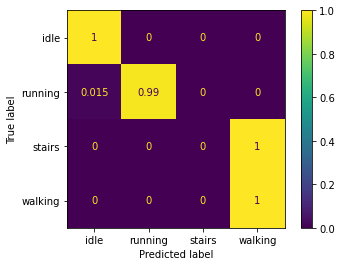

In [149]:
ConfusionMatrixDisplay.from_estimator(svm_model_poly, X_test, y_test, normalize='true')

### SVM: sigmoid

In [150]:
svm_model_sigmoid = svm.SVC(kernel='sigmoid')
svm_model_sigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [151]:
print("Efectividad del entreno:", svm_model_sigmoid.score(X_train, y_train))
print("Efectividad del test: ", svm_model_sigmoid.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_sigmoid.predict(X_test), average='macro'))

Efectividad del entreno: 0.8193074095569742
Efectividad del test:  0.8267594740912606
F1-Sore:  0.6094352835581394


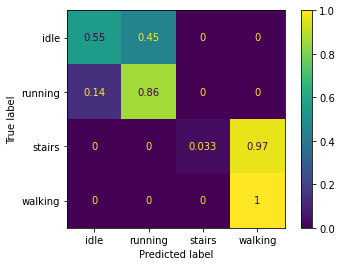

In [152]:
ConfusionMatrixDisplay.from_estimator(svm_model_sigmoid, X_test, y_test, normalize='true')

Con todos los distintos kernels de SVM no es posible obtener un buen resultado para todas las clases y a mas el tiempo de entreo es demasiado alto para las muestras que tenemos, asi que vamos a probar otro modelo para ver si este nos puede resolver el problema que tenemos.

### Decision Tree

entrenamos nuestro model

In [153]:
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

Observando las metricas son perfetas, obteniendo en el entrenamiento un accuracy de 1, y en el test un accuracy de 0.99

In [154]:
print("Efectividad del entreno:", decision_tree_model.score(X_train, y_train))
print("Efectividad del test: ", decision_tree_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, decision_tree_model.predict(X_test), average='macro'))

Efectividad del entreno: 1.0
Efectividad del test:  0.9706109822119103
F1-Sore:  0.8059705872460154


observamos la matriz de confusion

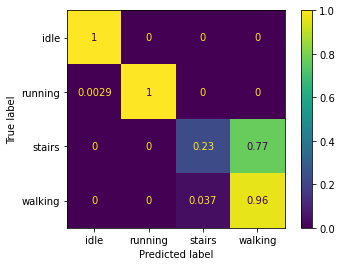

In [155]:
ConfusionMatrixDisplay.from_estimator(decision_tree_model, X_test, y_test, normalize='true')

observamos el arbol de decision

[Text(239.068125, 212.004, 'X[1] <= -3.463\ngini = 0.614\nsamples = 5169\nvalue = [819, 2719, 135, 1496]'),
 Text(160.07625000000002, 201.132, 'X[0] <= 0.807\ngini = 0.152\nsamples = 1631\nvalue = [0, 0, 135, 1496]'),
 Text(79.89545454545456, 190.26, 'X[2] <= -1.117\ngini = 0.088\nsamples = 1471\nvalue = [0, 0, 68, 1403]'),
 Text(40.328181818181825, 179.388, 'X[2] <= -4.199\ngini = 0.032\nsamples = 1112\nvalue = [0, 0, 18, 1094]'),
 Text(37.28454545454546, 168.516, 'gini = 0.0\nsamples = 328\nvalue = [0, 0, 0, 328]'),
 Text(43.371818181818185, 168.516, 'X[2] <= -4.199\ngini = 0.045\nsamples = 784\nvalue = [0, 0, 18, 766]'),
 Text(40.328181818181825, 157.644, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]'),
 Text(46.41545454545455, 157.644, 'X[2] <= -3.238\ngini = 0.042\nsamples = 783\nvalue = [0, 0, 17, 766]'),
 Text(38.04545454545455, 146.772, 'X[2] <= -3.247\ngini = 0.061\nsamples = 480\nvalue = [0, 0, 15, 465]'),
 Text(35.00181818181819, 135.9, 'X[2] <= -3.496\ngini = 0.053\nsample

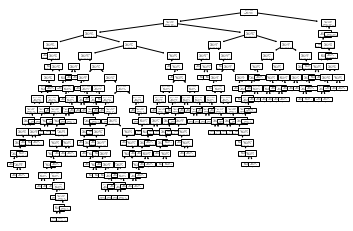

In [156]:
tree.plot_tree(decision_tree_model)

### Random forest

In [157]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [158]:
print("Efectividad del entreno:", random_forest_model.score(X_train, y_train))
print("Efectividad del test: ", random_forest_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, random_forest_model.predict(X_test), average='macro'))

Efectividad del entreno: 1.0
Efectividad del test:  0.974477958236659
F1-Sore:  0.8243302533019905


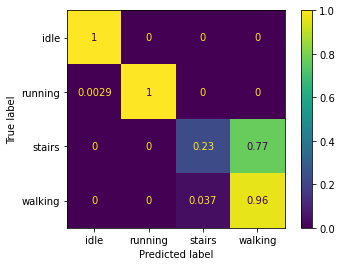

In [159]:
ConfusionMatrixDisplay.from_estimator(decision_tree_model, X_test, y_test, normalize='true')

## Validacion de modelos

In [160]:
modelos = pd.DataFrame(columns=["modelo","mean", "std"])

### SVM: rbf

In [161]:
cross_val_svm = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_svm.mean()
std = cross_val_svm.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_rbf', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.7360616678914236
Desviacion estandar: 0.00229418551697658


## SVM: linear

In [162]:
cross_val_svm_linear = cross_val_score(svm_model_linear, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_svm_linear.mean()
std = cross_val_svm_linear.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_linear', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.7080472738569397
Desviacion estandar: 0.007638586658690378


### SVM: poly

In [163]:
cross_val_svm_poly = cross_val_score(svm_model_poly, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_svm_poly.mean()
std = cross_val_svm_poly.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_poly', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.7341278683289907
Desviacion estandar: 0.003490557429746939


### SVM: sigmoide

In [164]:
cross_val_svm_sigmoid = cross_val_score(svm_model_sigmoid, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_svm_sigmoid.mean()
std = cross_val_svm_sigmoid.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_sigmoide', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.5882016441030251
Desviacion estandar: 0.022474484060974506


### Decision Tree

In [165]:
cross_val_decision_tree = cross_val_score(decision_tree_model, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_decision_tree.mean()
std = cross_val_decision_tree.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'Decision tree', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.8426657041695798
Desviacion estandar: 0.030327380232073792


### Random forest

In [166]:
cross_val_random_forest = cross_val_score(random_forest_model, X_train, y_train, cv=10, scoring='f1_macro')
mean = cross_val_random_forest.mean()
std = cross_val_random_forest.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'Random Forest', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.8561258764302402
Desviacion estandar: 0.0518638285546113


## Comparativas de modelos

Tras la realizacion del cross validation vamos a mostrar los resultados ordenados por score para poder tener de una forma mas clara que modelo es mejor para nuestro problema

In [167]:
modelos.sort_values(by="mean", ascending=False)

,modelo,mean,std
5,Random Forest,0.856126,0.051864
4,Decision tree,0.842666,0.030327
0,SVM_rbf,0.736062,0.002294
2,SVM_poly,0.734128,0.003491
1,SVM_linear,0.708047,0.007639
3,SVM_sigmoide,0.588202,0.022474


## Conclusiones

Tras haber comparado diferentes modelos podemos decir que los mejores modelos son el Random forest y el Deision tree, ambos con unas metricas y desviaion estandar muy parecidas, pero no podremos obtener un maximo de acurray por el problema de la distribucion de lso datos, ya que lo que tiene todos en comun es que fallan a la hora de predecir la clase stairs por el hecho qwue tenemos muy pocas muestras de esta lase.